In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
sys.path.append("./..")

In [7]:
from src.numerical_methods import *

In [8]:
import json

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.models.resnet import resnet50


from architectures import get_architecture
from datasets import get_dataset, DATASETS, get_num_classes, get_normalize_layer

In [48]:
rng = jax.random.PRNGKey(33)
rng, key = jax.random.split(rng)

In [10]:
# normal_samples = jax.vmap(norm)(subkeys)

In [11]:
key.shape

(2,)

In [89]:
ns = 10_000
normal_samples = jax.random.normal(key, [100_000])

In [13]:
len(normal_samples)

100000

In [18]:
sigma_blur = 3

In [19]:
def norm_to_exp(c, lam):
    print(c.shape)
    idx = np.random.randint(0, len(normal_samples), (c.shape[0], 4))
    q = normal_samples[idx]
#     return jax.numpy.abs(c[0] * q[0] - q[1] * q[2]) / lam
    
    return jax.numpy.abs(q[:, 0] * q[:, 1] - q[:, 2] * q[:, 3]) / lam
    
    
def norm_to_ray(c, sigma):
    idx = np.random.randint(0, len(normal_samples), (c.shape[0], 2))
    c01 = normal_samples[idx] * sigma 
#     c = c * sigma
    return jnp.sqrt(c01[:, 0] ** 2 + c01[:, 1] ** 2)

In [101]:
def norm_to_exp_1d(c, lam):

    idx = np.random.randint(0, len(normal_samples), 4)
    q = normal_samples[idx]
    
    return jax.numpy.abs(q[0] * q[1] - q[2] * q[3]) / lam
    
    
def norm_to_ray_1d(c, sigma):
    idx = np.random.randint(0, len(normal_samples), 2)
    c01 = normal_samples[idx] * sigma 
    c = c * sigma
    return jnp.sqrt(c ** 2 + c01[1] ** 2)

In [91]:
def norm_to_exp_torch(s, lam):
    norm1 = torch.randn(s)
    norm2 = torch.randn(s)
    norm3 = torch.randn(s)
    norm4 = torch.randn(s)
    return torch.abs(norm1 * norm2 - norm3 * norm4) / lam
    

In [83]:
norm_to_exp_1d(jax.random.normal(key), 2)

Array(0.12954232, dtype=float32)

In [21]:
norm_samples = torch.randn(ns).numpy()

(10000,)


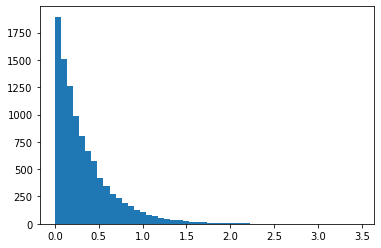

In [22]:
plt.hist(np.array(norm_to_exp(norm_samples, lam=sigma_blur)), bins=50)
plt.show()

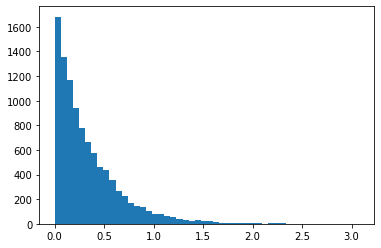

In [23]:
exp_true = np.random.exponential(scale =1/sigma_blur, size=10000)
plt.hist(exp_true, bins=50)
plt.show()

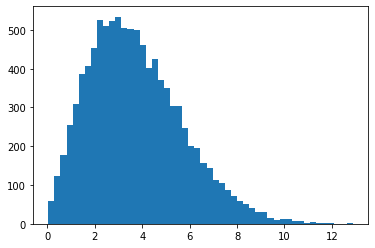

In [24]:
plt.hist(np.array(norm_to_ray(norm_samples, sigma=sigma_blur)), bins=50)
plt.show()

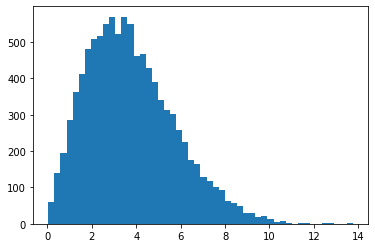

In [25]:
ray_true = np.random.rayleigh(scale=sigma_blur, size=10000)
plt.hist(ray_true, bins=50)
plt.show()

# TBrBlC

In [6]:
def fun(betas, b_zero, betas_list, x_0, gamma, key, ns, type_of_transform):
    d = b_zero.shape[0]
    shape = [b.shape[0] for b in betas_list]
    print(shape)
    bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)
    x, xi = pxi_to_xi(p)
    
    
    z = csaps(betas_list, g.reshape(*shape))
    hg = []

    for beta in tqdm(betas):
        hat_g = g_to_hat_g(z, beta, b_zero)
        hg.append(hat_g)


    hat_g = jnp.asarray(hg)
    
    hatg_int = csaps(betas_list, hat_g.reshape(*shape)) 
    
    return hatg_int

In [102]:
def norm_to_exp_old(a):
    return jnp.log(2/jax.lax.erfc(a/jnp.sqrt(2)))

In [103]:
sigma_b = 0.4
sigma_c = 0.4
sigma_tr = 30
sigma_gamma = 1.1 
sigma_blur = 30

def gamma(x, b, c, tr_type:str):

    if tr_type == 'brightness':
        c = c / DEFAULT_SIGMA * sigma_b
        return b+c
    
    if tr_type == 'cb':
        # contrast then brightness
        c0 = c[0] / DEFAULT_SIGMA * sigma_c
        c1 = c[1] / DEFAULT_SIGMA *sigma_b
        
        b1 = norm_to_lognorm(c0)*b[0]
        
        b2 = b[1]*norm_to_lognorm(c0) + c1
        return jnp.array([b1,b2])
    
    if tr_type == 'gc': ##gamma-contrast
        c0 = c[0] / DEFAULT_SIGMA
        c1 = c[1] / DEFAULT_SIGMA * sigma_c
       
        c0 = norm_to_ray_1d(c0, sigma_gamma)
    
        b1 = b[0]*c0
        b2 = b[1]**c0 * norm_to_lognorm(c1)
        return jnp.array([b1, b2])
    
    
    if tr_type == 'bt': 
        
        c0 = c[0] / DEFAULT_SIGMA * sigma_b
        c1 = c[1] / DEFAULT_SIGMA * sigma_tr
        c2 = c[2] / DEFAULT_SIGMA * sigma_tr

        b1 = b[0] + c0
        b2 = b[1] + c1 
        b3 = b[2] + c2
        return jnp.array([b1, b2, b3])
    
    

    if tr_type == 'tbbc': #translation -  -Blur- Brightness - Contrast
        # Norm(0, 1) -> Laplace(1/sigma_blur) -> Exp(sigma_blur)
        c0 = c[0] / DEFAULT_SIGMA * sigma_tr
        c1 = c[1] / DEFAULT_SIGMA * sigma_tr
        c2 = c[2] / DEFAULT_SIGMA #* sigma_blur
        c3 = c[3] / DEFAULT_SIGMA * sigma_b
        c4 = c[5] / DEFAULT_SIGMA * sigma_c
        
        x2 = jax.random.normal(key)
        x3 = jax.random.normal(key)
        x4 = jax.random.normal(key)
        c2 = norm_to_exp_1d(c2, sigma_blur)
        b0 = b[0] + c0
        b1 = b[1] + c1
#         b2 = b[2] + norm_to_exp(c2) * sigma_blur
        b2 = b[2] + c2
        b3 = b[3] + c3 / b[4]
        b4 = norm_to_lognorm(c4)*b[4]
        
        return jnp.array([b0,b1,b2,b3,b4])
    
    if tr_type == 'tbbc_ray': #translation -  -Blur- Brightness - Contrast
        
        c0 = c[0] / DEFAULT_SIGMA * sigma_tr
        c1 = c[1] / DEFAULT_SIGMA * sigma_tr
        c2 = c[2] / DEFAULT_SIGMA
        c3 = c[3] / DEFAULT_SIGMA * sigma_b
        c4 = c[5] / DEFAULT_SIGMA * sigma_c
        

        
        c2 = norm_to_ray_1d(c2, sigma_blur)
        
        b0 = b[0] + c0
        b1 = b[1] + c1
        b2 = b[2] + c2
        b3 = b[3] + c3 / b[4]
        b4 = norm_to_lognorm(c4)*b[4]
        
        return jnp.array([b0,b1,b2,b3,b4])
    
    if tr_type == 'tr': #translation -  -Blur- Brightness - Contrast
        
        c0 = c[0]*sigma_tr
        c1 = c[1]*sigma_tr
        
        
        b0 = b[0] + c0
        b1 = b[1] + c1
        
        return jnp.array([b0,b1])
    
    if tr_type == 'ct': 
        
        c0 = c[0] / DEFAULT_SIGMA *sigma_c
        c1 = c[1] / DEFAULT_SIGMA *sigma_tr
        c2 = c[2] / DEFAULT_SIGMA *sigma_tr
        
        
        b0 = b[0]*norm_to_lognorm(c0)
        b1 = b[1] + c1
        b2 = b[2] + c2

        return jnp.array([b0,b1,b2])
    
    if tr_type == 'blur': 
        # Norm(0, 1) -> Laplace(1/sigma_blur) -> Exp(sigma_blur)
#         idx = np.random.randint(0, len(normal_samples), 2)
#         c01, c02 = normal_samples[idx]
#         c0 = c[0] * sigma_blur 
#         c01 = c01 * sigma_blur
#         c02 = c02 * sigma_blur
#         b0 = b[0] + jnp.sqrt(c01 ** 2 + c02 ** 2)
        
        b0 = b[0] + norm_to_exp_1d(c[0], sigma_blur)

        return jnp.array([b0])
    
    if tr_type == 'blur_ray': 
        c0 = c[0] / DEFAULT_SIGMA
        c0 = norm_to_ray_1d(c0, sigma_blur)
        b0 = b[0] + c0
#         b0 = b[0] + norm_to_ray(c[0] / DEFAULT_SIGMA) * sigma_blur

        return jnp.array([b0])

In [10]:
# hatg_int = fun(betas, b_zero, betas_list, x0, gamma, key, ns, type_of_transform)

100%|█████████████████████████████████████████| 720/720 [00:55<00:00, 12.92it/s]


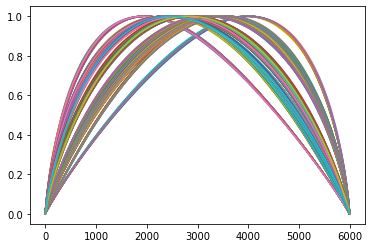

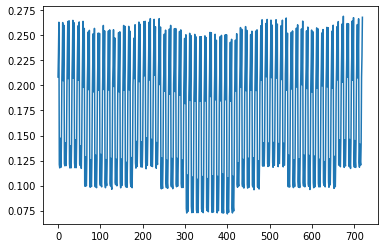

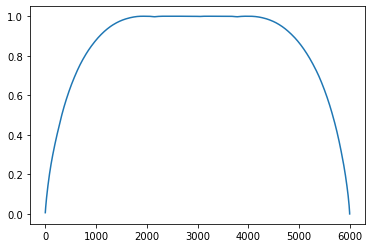

In [136]:
ns = 6000
x0 = jnp.array(torch.randn(3, 224, 224)) # np.array([1.0,3.0, 3., 1, 1.1]) #additive
d = 5
b_zero = jnp.array([0., 0., 0., 0.0, 1.0])
betas1 = jnp.linspace(-5., 5., 3).astype(int) * 1.0
betas2 = jnp.linspace(-5., 5., 4).astype(int) * 1.0
betas3 = jnp.linspace(0, 3.0, 5)
betas4 = jnp.linspace(-0.2, 0.2, 4)
betas5 = jnp.linspace(0.9, 1.2, 3)

betas_list = [betas1, betas2, betas3, betas4, betas5]
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4, betas5)))) 

type_of_transform = 'tbbc'

bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)

for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

100%|█████████████████████████████████████████| 432/432 [00:32<00:00, 13.10it/s]


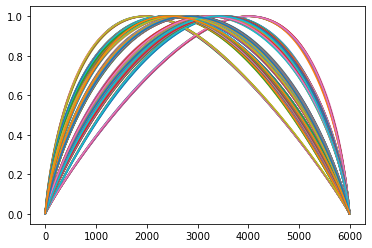

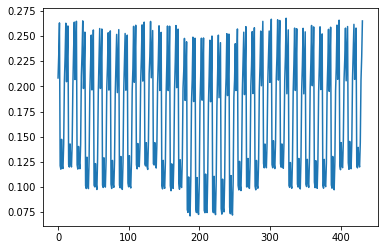

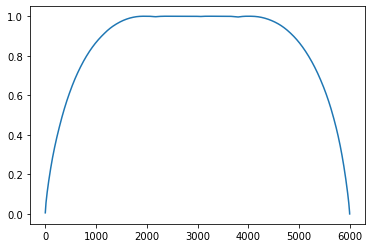

In [119]:
ns = 6000
x0 = jnp.array([1.0,3.0, 3., 1, 1.1]) #additive
d = 5
b_zero = jnp.array([0., 0., 0., 0.0, 1.0])
betas1 = jnp.linspace(-5., 5., 3).astype(int) * 1.0
betas2 = jnp.linspace(-5., 5., 4).astype(int) * 1.0
betas3 = jnp.linspace(0.01, 1.0, 3)
betas4 = jnp.linspace(-0.2, 0.2, 4)
betas5 = jnp.linspace(0.9, 1.2, 3)

betas_list = [betas1, betas2, betas3, betas4, betas5]
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4, betas5)))) 

type_of_transform = 'tbbc_ray'

bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)

for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

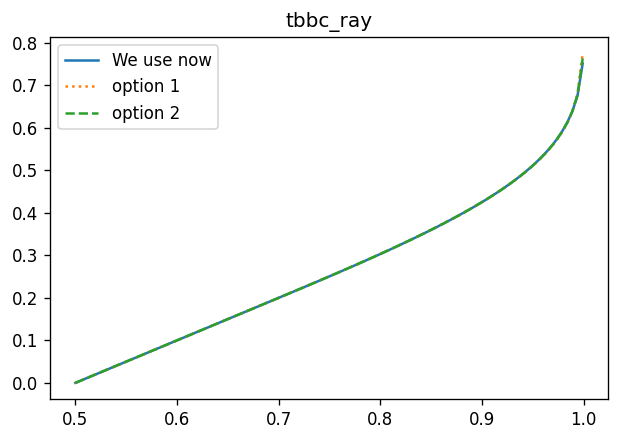

In [120]:
xs = np.linspace(0.5, 1-1e-3, 100)
our_rad = lambda h: -xi(1 - h) + xi(0.5)
our_rad1 = lambda h: xi(h) - xi(0.5)
our_rad2 = lambda h: (xi(h) - xi(1-h))/2
plt.figure(dpi=120)
plt.title(type_of_transform)
plt.plot(xs, our_rad(xs), label='We use now')
plt.plot(xs, our_rad1(xs), label='option 1', linestyle=":")
plt.plot(xs, our_rad2(xs), label='option 2', linestyle="--")
plt.legend()
plt.show()


100%|█████████████████████████████████████████| 960/960 [00:14<00:00, 68.15it/s]


(960, 5000)
(960,)
(5000,)


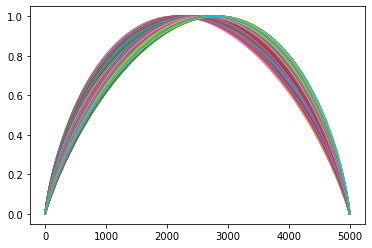

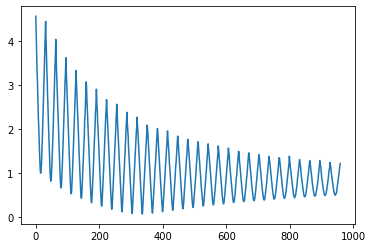

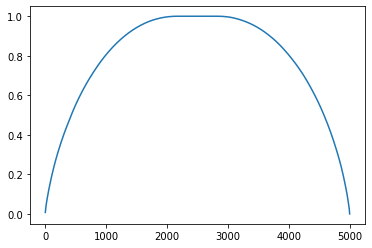

In [139]:
ns = 5000
x0 = jnp.array([1.0,0.5]) #additive
d = 2
b_zero = jnp.array([1., 0.])

betas1 = jnp.linspace(0.5, 2., 30)
betas2 = jnp.linspace(-2., 2., 32)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2)))) #betas1.reshape(-1,1) 

type_of_transform = 'cb'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)
x, xi = pxi_to_xi(p)

for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

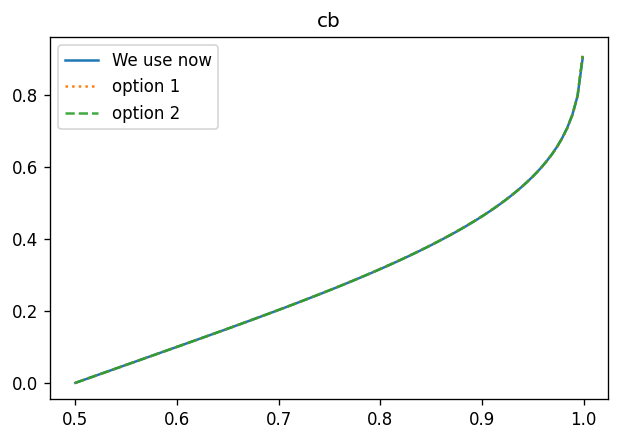

In [122]:
xs = np.linspace(0.5, 1-1e-3, 100)
our_rad = lambda h: -xi(1 - h) + xi(0.5)
our_rad1 = lambda h: xi(h) - xi(0.5)
our_rad2 = lambda h: (xi(h) - xi(1-h))/2
plt.figure(dpi=120)
plt.title(type_of_transform)
plt.plot(xs, our_rad(xs), label='We use now')
plt.plot(xs, our_rad1(xs), label='option 1', linestyle=":")
plt.plot(xs, our_rad2(xs), label='option 2', linestyle="--", alpha=0.9)
plt.legend()
plt.show()


100%|██████████████████████████████████████████| 32/32 [00:00<00:00, 276.39it/s]


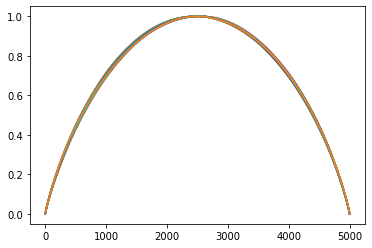

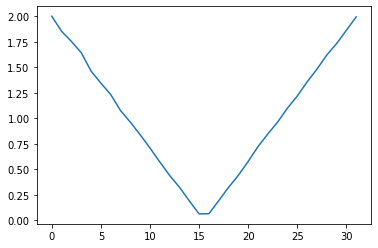

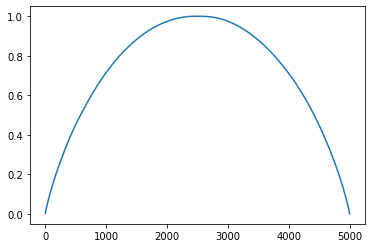

In [123]:
ns = 5000
x0 = jnp.array([1.0]) #additive
d = 1
b_zero = jnp.array([0.])


betas1 = jnp.linspace(-2., 2., 32)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1)))) #betas1.reshape(-1,1) 

type_of_transform = 'brightness'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)
x, xi = pxi_to_xi(p)

for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

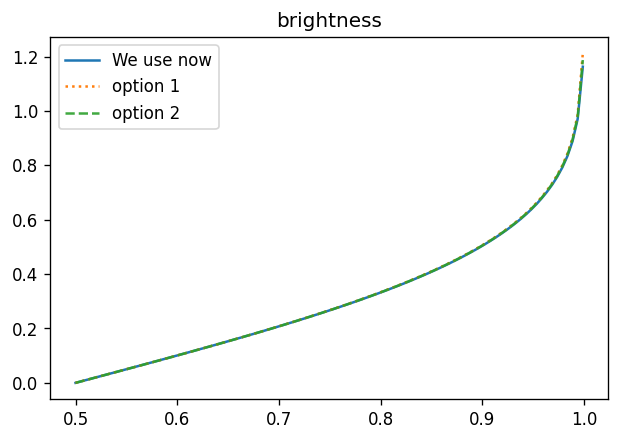

In [124]:
xs = np.linspace(0.5, 1-1e-3, 100)
our_rad = lambda h: -xi(1 - h) + xi(0.5)
our_rad1 = lambda h: xi(h) - xi(0.5)
our_rad2 = lambda h: (xi(h) - xi(1-h))/2
plt.figure(dpi=120)
plt.title(type_of_transform)
plt.plot(xs, our_rad(xs), label='We use now')
plt.plot(xs, our_rad1(xs), label='option 1', linestyle=":")
plt.plot(xs, our_rad2(xs), label='option 2', linestyle="--", alpha=0.9)
plt.legend()
plt.show()


100%|██████████████████████████████████████| 1440/1440 [00:09<00:00, 149.06it/s]


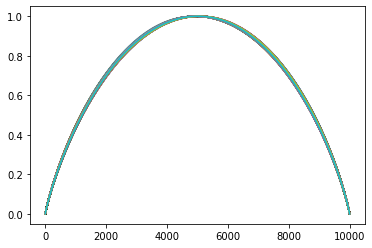

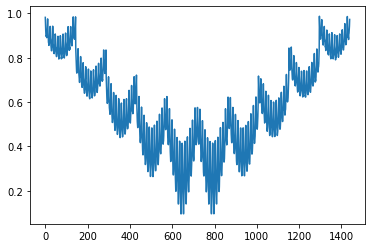

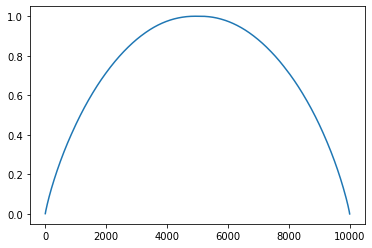

In [125]:
#Brightness + Translation
ns = 10000
x0 = jnp.array([1.0,3.0, 3.]) #additive
d = 3
b_zero = jnp.array([0., 0., 0.])
betas1 = jnp.linspace(-0.8, 0.8, 10)

betas2 = jnp.linspace(-30., 30., 12).astype(int) * 1.0
betas3 = jnp.linspace(-30., 30., 12).astype(int) * 1.0
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3)))) 

type_of_transform = 'bt'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)

for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

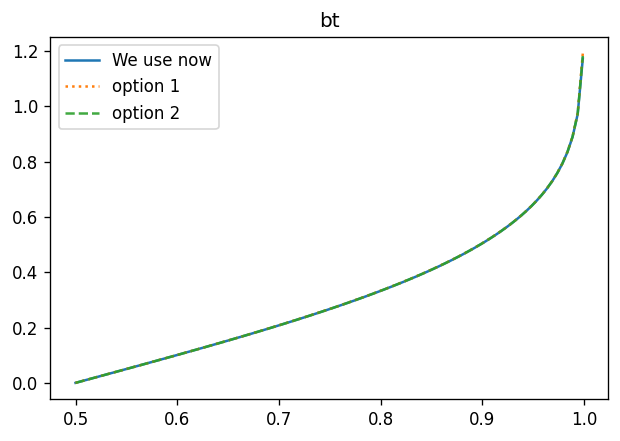

In [126]:
xs = np.linspace(0.5, 1-1e-3, 100)
our_rad = lambda h: -xi(1 - h) + xi(0.5)
our_rad1 = lambda h: xi(h) - xi(0.5)
our_rad2 = lambda h: (xi(h) - xi(1-h))/2
plt.figure(dpi=120)
plt.title(type_of_transform)
plt.plot(xs, our_rad(xs), label='We use now')
plt.plot(xs, our_rad1(xs), label='option 1', linestyle=":")
plt.plot(xs, our_rad2(xs), label='option 2', linestyle="--", alpha=0.9)
plt.legend()
plt.show()


100%|█████████████████████████████████████████| 960/960 [00:33<00:00, 28.50it/s]


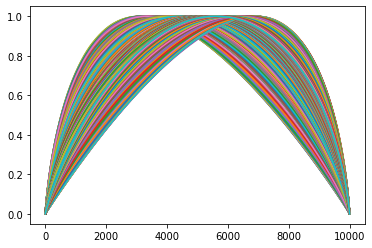

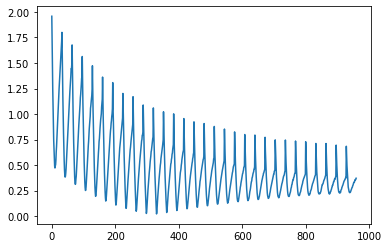

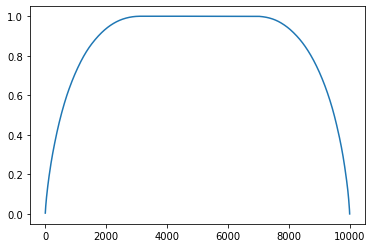

In [127]:
ns = 10000
x0 = jnp.array([1.5,1.5]) #additive
d = 2
b_zero = jnp.array([1., 1.])

betas1 = jnp.linspace(0.5, 2, 30)
betas2 = jnp.linspace(0.5, 2., 32)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2)))) #betas1.reshape(-1,1) 

# betas = jnp.linspace(0.5, 2, 500)
# betas = jnp.resize(betas, (*betas.shape, 1))
type_of_transform = 'gc'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)

for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

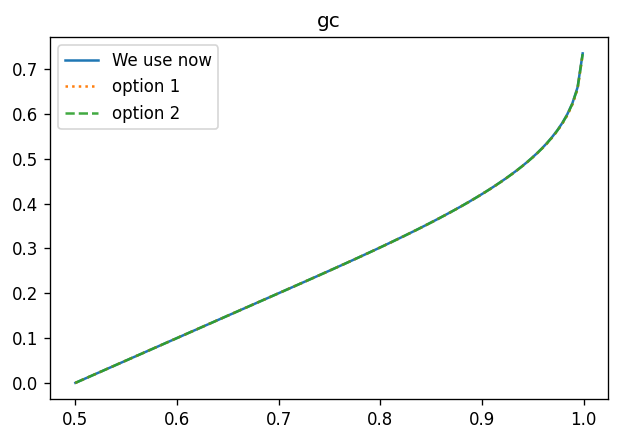

In [128]:
xs = np.linspace(0.5, 1-1e-3, 100)
our_rad = lambda h: -xi(1 - h) + xi(0.5)
our_rad1 = lambda h: xi(h) - xi(0.5)
our_rad2 = lambda h: (xi(h) - xi(1-h))/2
plt.figure(dpi=120)
plt.title(type_of_transform)
plt.plot(xs, our_rad(xs), label='We use now')
plt.plot(xs, our_rad1(xs), label='option 1', linestyle=":")
plt.plot(xs, our_rad2(xs), label='option 2', linestyle="--", alpha=0.9)
plt.legend()
plt.show()


100%|███████████████████████████████████████| 3468/3468 [00:56<00:00, 61.35it/s]


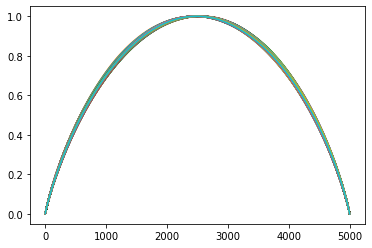

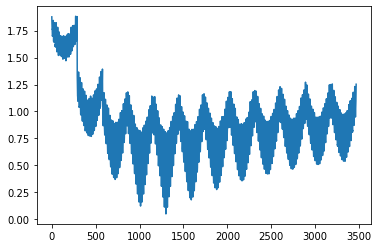

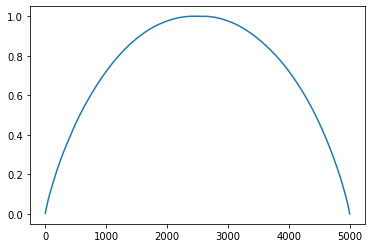

In [129]:
ns = 5000
x0 = jnp.array([1.1,0.3]) # WHATEVER 
d = 3
b_zero = jnp.array([1.0, 0.0, 0.0])

betas1 = jnp.linspace(0.4, 2.2, 12) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-60, 60, 17)
betas3 = jnp.linspace(-60, 60, 17)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3)))) 

type_of_transform = 'ct'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)

for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

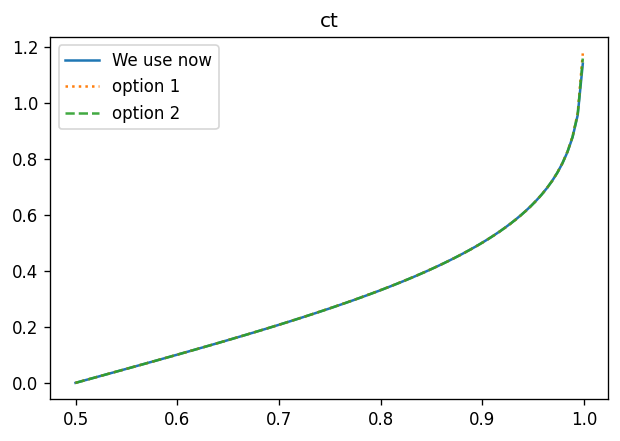

In [130]:
xs = np.linspace(0.5, 1-1e-3, 100)
our_rad = lambda h: -xi(1 - h) + xi(0.5)
our_rad1 = lambda h: xi(h) - xi(0.5)
our_rad2 = lambda h: (xi(h) - xi(1-h))/2
plt.figure(dpi=120)
plt.title(type_of_transform)
plt.plot(xs, our_rad(xs), label='We use now')
plt.plot(xs, our_rad1(xs), label='option 1', linestyle=":")
plt.plot(xs, our_rad2(xs), label='option 2', linestyle="--", alpha=0.9)
plt.legend()
plt.show()


In [55]:
def norm_to_exp(a):
    
    return jnp.log(2/jax.lax.erfc(a/jnp.sqrt(2)))

In [46]:
def norm_to_exp(a, lam):
#     lam = 1

    h = 0.5 * (1 + jax.lax.erf(a / jnp.sqrt(2) / DEFAULT_SIGMA))
    
    
    return - lam * jnp.log(1 - h)

In [47]:
xs = np.random.randn(1000)

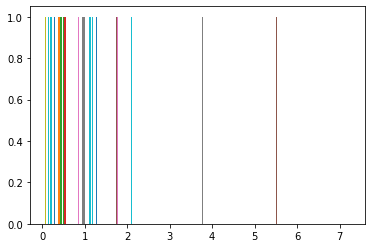

In [48]:
plt.hist(norm_to_exp1(xs))
plt.show()

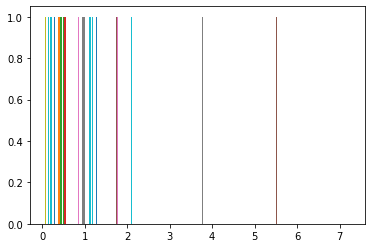

In [53]:
plt.hist(norm_to_exp(xs, lam=1))
plt.show()

In [49]:
norm_to_exp1(10)

Array(53.231285, dtype=float32, weak_type=True)

In [50]:
norm_to_exp(6, lam=1)

Array(inf, dtype=float32, weak_type=True)

In [51]:
DEFAULT_SIGMA

1.0

In [12]:
x.shape

(5000,)

In [13]:
bounds.shape

(32, 5000)

In [15]:
p.shape

(5000,)

100%|███████████████████████████████████████████| 64/64 [00:01<00:00, 46.02it/s]


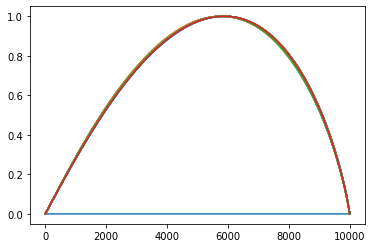

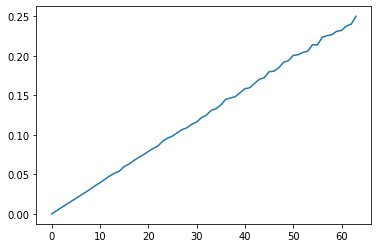

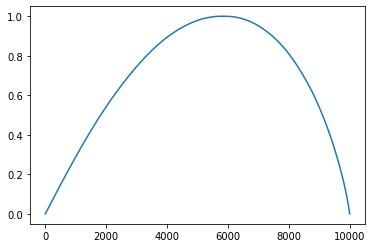

In [131]:
ns = 10000
x0 = jnp.array([2]) #additive
d = 1
b_zero = jnp.array([0])


betas1 = jnp.linspace(0, 32., 64)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1)))) #betas1.reshape(-1,1) 

type_of_transform = 'blur_ray'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)
x, xi = pxi_to_xi(p)

for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

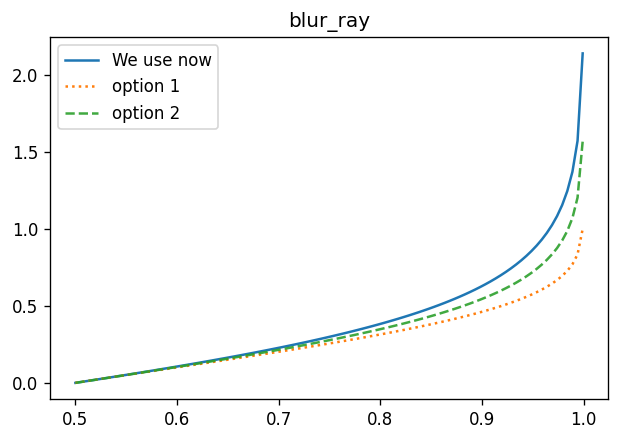

In [132]:
xs = np.linspace(0.5, 1-1e-3, 100)
our_rad = lambda h: -xi(1 - h) + xi(0.5)
our_rad1 = lambda h: xi(h) - xi(0.5)
our_rad2 = lambda h: (xi(h) - xi(1-h))/2
plt.figure(dpi=120)
plt.title(type_of_transform)
plt.plot(xs, our_rad(xs), label='We use now')
plt.plot(xs, our_rad1(xs), label='option 1', linestyle=":")
plt.plot(xs, our_rad2(xs), label='option 2', linestyle="--", alpha=0.9)
plt.legend()
plt.show()


100%|██████████████████████████████████████████| 64/64 [00:00<00:00, 129.62it/s]


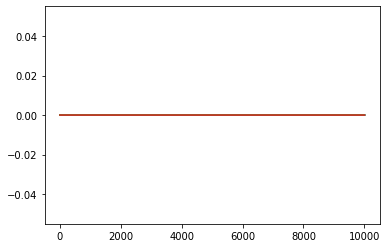

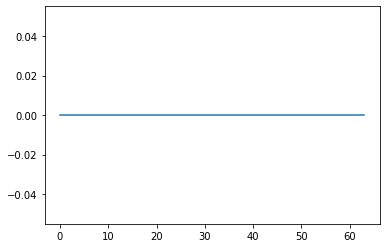

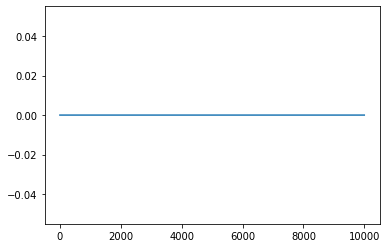

In [133]:
sigma_blur = 4

ns = 10000
x0 = jnp.array([0]) #additive
d = 1
b_zero = jnp.array([0])

betas1 = jnp.linspace(0, 32., 64)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1)))) #betas1.reshape(-1,1) 

type_of_transform = 'blur'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)
x, xi = pxi_to_xi(p)

for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

In [ ]:
xs = np.linspace(0.5, 1-1e-3, 100)
our_rad = lambda h: -xi(1 - h) + xi(0.5)
our_rad1 = lambda h: xi(h) - xi(0.5)
our_rad2 = lambda h: (xi(h) - xi(1-h))/2
plt.figure(dpi=120)
plt.title(type_of_transform)
plt.plot(xs, our_rad(xs), label='We use now')
plt.plot(xs, our_rad1(xs), label='option 1', linestyle=":")
plt.plot(xs, our_rad2(xs), label='option 2', linestyle="--", alpha=0.9)
plt.legend()
plt.show()


In [11]:
z = csaps([betas1, betas2 ,betas3, betas4, betas5], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape,*betas4.shape, *betas5.shape ))

In [ ]:
betas

In [12]:
hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)
    
    
hat_g = jnp.asarray(hg)

100%|█████████████████████████████████████████| 432/432 [00:05<00:00, 79.72it/s]


### interpolate the integral of g(beta)

In [17]:
hatg_int = csaps([betas1, betas2, betas3, betas4, betas5], hat_g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape, *betas5.shape)) 
#hatg_int = csaps([betas1, betas2], hat_g.reshape(*betas1.shape, *betas2.shape)) #2d

In [21]:
output_json = json.load(open('./../results/translation_blur_brightness_contrast_pa.json'))
correct = np.array(output_json['is_correct']) 
hs = np.array(output_json['pa'])

In [22]:
correct.mean()

0.2

In [23]:
for h1, isCorrect in zip(hs, correct):
    print(h1, isCorrect)
    break

0.18470631464675533 0


In [24]:
print(h1)
h1 = 0.54
safe_beta(xi, h1, hatg_int, [0.6, 0.0, 0.2, 0.2, 0.2])

0.18470631464675533


array([[[[[False]]]]])

In [25]:
beta_d = { 't1':list(), 't2':list(), 'bl': list(),'b': list(),'c': list()}
accuracy = np.zeros(len(betas))

len(betas)

for i, beta in (enumerate(tqdm(betas))):
   
    beta_d['t1'].append(beta[0])
    beta_d['t2'].append(beta[1])
    beta_d['bl'].append(beta[2])
    beta_d['b'].append(beta[3])
    beta_d['c'].append(beta[4])
    
    for h1, isOk in zip(hs, correct):
        accuracy[i] += (safe_beta(xi, h1, hatg_int, (beta[0],beta[1], beta[2], beta[3], beta[4])).item() * isOk)
    accuracy[i] /= len(correct)
    #break

100%|█████████████████████████████████████████| 432/432 [02:09<00:00,  3.34it/s]


In [26]:
accuracy

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.

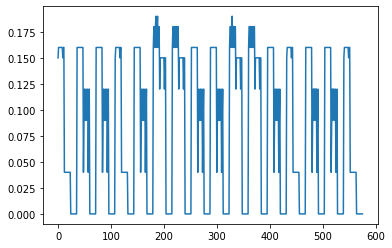

In [69]:
plt.plot(accuracy)